# DATA Preparations for the model

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import datetime
import math
import glob
from random import *
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
PATH = 'E:/Datasets/SOCOFing/Ready/latent_image_processed_gae_96/'

high_blur_list_train = [f for f in glob.glob(PATH + 'high_blur_*.BMP')]
high_blur_list_train.sort()

original_list_train = [f for f in glob.glob(PATH + 'original_*.BMP')]
original_list_train.sort()

In [3]:
PATH = 'E:/Datasets/SOCOFing/Ready/latent_image_processed_gae_96_test/'

high_blur_list_test = [f for f in glob.glob(PATH + 'high_blur_*.BMP')]
high_blur_list_test.sort()

original_list_test = [f for f in glob.glob(PATH + 'original_*.BMP')]
original_list_test.sort()

In [4]:
def make_image_list(image_list):
    result_image_list = []

    if (len(image_list) != 0):
        image_list.sort()
        for i in range(len(image_list)):
            temp = cv2.imread(image_list[i], 0)/255.0
            result_image_list.append(temp)
        
    return result_image_list

In [5]:
train_x = make_image_list(high_blur_list_train)
train_y = make_image_list(original_list_train)

test_x = make_image_list(high_blur_list_test)
test_y = make_image_list(original_list_test)

In [10]:
PATH = 'E:/Datasets/SOCOFing/Ready/latent_image_processed_gae_96/'

In [11]:
train_path_list = [f for f in glob.glob(PATH + "*")]

In [12]:
print(train_path_list[0])

E:/Datasets/SOCOFing/Ready/latent_image_processed_gae_96\high_blur_0.BMP


# Experiment Parameters

In [122]:
EXPERIMENTAL_ID = 6

In [123]:
# Model and Process Parameters
GAUSS_BLOCK_KERNEL_SIZE = 7
GAUSS_BLOCK_SIGMA = 1
GAUSS_ORIENT_KERNEL_SIZE = 13 
GAUSS_ORIENT_SIGMA = 2

MIN_N_FILTER = 64

GRAD_WEIGHT = 1
ORI_WEIGHT = 1
REL_WEIGHT = 1

MAGIC_NUMBER_REL = 1

In [124]:
# Hyper Parameters for Adam (DEFAULT :# WEIGHT_DECAY=0, MOMENTUM=0.9, LR=1e-3, EPSILON=1e-8)
WEIGHT_DECAY = 1e-4      
MOMENTUM     = 0.9          
LR           = 1e-4       # initial learning rate
EPSILON      = 1e-8

In [125]:
# Trainning Hyper Parameters 
# (Batch size should be a factor of X_train)
BATCH_SIZE = 130 
EPOCH      = 15

# THE gae model

<b><i>input</i></b><br>
<u>Problem latent image of size 96*96</u>

<b><i>output</i></b><br>
<u>Enhanced latent image of size 96*96</u>



In [52]:
# # THE AUTO ENCODER Assume cov2d resize as 0.5 
# def define_autoencoder(image_shape=(96,96,1)):

#     iterations = 0
#     temp = image_shape[0]

#     while(temp %2 == 0):
#         temp = temp/2
#         iterations = iterations+1
#         print(temp)
        
#     print(iterations)
#     input_layer = Input(shape=image_shape)
#     x = input_layer
#     for i in range(iterations):
#         if (i != 0):
#             if (i == iterations-1 and iterations % 2 == 0):
#                 x = Conv2D(N_CONV_FILTER, kernel_size=(3,3), padding='same')(x)
#             else:
#                 x = Conv2D(N_CONV_FILTER/2**(iterations-i), kernel_size=(3,3), strides=(2,2), padding='same')(x)
#         else:
#             x = Conv2D(N_CONV_FILTER/2**(iterations-i), kernel_size=(3,3), strides=(2,2), padding='same')(input_layer)
#         x = BatchNormalization()(x)
#         x = LeakyReLU(alpha=0.2)(x)

#     if (iterations % 2 != 0):
#         x = Conv2D(N_CONV_FILTER, kernel_size=(3,3), padding='same')(x)
#         x = BatchNormalization()(x)
#         x = LeakyReLU(alpha=0.2)(x)
        
#     for i in range(iterations):
#         x = Conv2DTranspose(N_CONV_FILTER/2**i, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
#         x = BatchNormalization()(x)
#         x = ReLU()(x)
        
#     output_layer = Conv2DTranspose(1, kernel_size=(image_shape[0],image_shape[1]), padding='same')(x)
#     model = Model(input_layer,output_layer)
    
#     return model 

In [53]:
# THE AUTO ENCODER Assume cov2d resize as 0.5 
# min_ks = minimum kernel size eg. (3,3)
def define_autoencoder(image_shape=(96,96,1), min_n_filter=32, min_ks=3):
    if image_shape[0] != image_shape[1]:
        print('image shape should be square')
        return
    
    iterations = 0
    temp = image_shape[0]
    
    while(temp % 2 == 0):
        temp = temp / 2
        iterations = iterations + 1
    max_ks = min_ks+(2*iterations)
    # max_ks = 3+(2*5) = 13
    ## ENCODER ##
    input_layer = Input(shape=image_shape)
    x = input_layer
    for i in range(iterations):
        
        asc_n_filter = min_n_filter * (2 ** i)
        desc_kernel_size = (max_ks - (2 * i), max_ks - (2 * i))
        
        if (i != 0):
            x = Conv2D(asc_n_filter, kernel_size=desc_kernel_size, strides=(2,2), padding='same')(x)
        else:
            x = Conv2D(min_n_filter, kernel_size=(max_ks,max_ks), strides=(2,2), padding='same')(input_layer)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
    
    ## DECODER ##
    for i in range(iterations):
        
        desc_n_filter = min_n_filter * (2 ** (iterations - i - 2))
        asc_kernel_size = (min_ks + (2 * (i + 1)),min_ks + (2 * (i + 1)))
        
        x = Conv2DTranspose(desc_n_filter, kernel_size=asc_kernel_size, strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
   
    
    output_layer = Conv2DTranspose(1, kernel_size=(image_shape[0],image_shape[1]), padding='same')(x)
    model = Model(input_layer,output_layer)
    
    return model 

In [54]:
model = define_autoencoder(min_n_filter=MIN_N_FILTER)

In [55]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 64)        10880     
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 128)       991360    
_________________________________________________________________
batch_normalization_11 (Batc (None, 24, 24, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 24, 24, 128)       0   

In [56]:
def zero_padding(image, padding_size):
    if padding_size <= 0:
        return image

    height = image.shape[0]
    width = image.shape[1]

    zero_padding_image = np.zeros([height + (padding_size * 2), width + (padding_size * 2)], dtype=np.uint8)
    zero_padding_height = zero_padding_image.shape[0]
    zero_padding_width = zero_padding_image.shape[1]

    row_start = padding_size
    col_start = padding_size
    row_end = zero_padding_height - padding_size
    col_end = zero_padding_width - padding_size

    zero_padding_image[row_start:row_end, col_start:col_end] = image

    return zero_padding_image

In [57]:
# def convolute(image, filter, mode='sum'):
#     height, width = image.shape
#     result_image = np.zeros(image.shape, dtype=np.uint8)
#     padding_size = filter.shape[0] // 2
#     zero_padding_image = zero_padding(image, padding_size)
#     plt.imshow(zero_padding_image), plt.show()
#     flipped_filter = np.flip(filter)

#     for i in range(padding_size, height):
#         for j in range(padding_size, width):
#             conv_matrix = zero_padding_image[i-padding_size:i+padding_size+1, j-padding_size:j+padding_size+1] * flipped_filter
#         if mode == 'sum':
#             result_image[i][j] = np.absolute((np.sum(conv_matrix)).astype(np.uint8))
#         elif mode == 'median':
#             result_image[i][j] = np.absolute((np.median(conv_matrix)).astype(np.uint8))
#         elif mode == 'average':
#             result_image[i][j] = np.absolute((np.mean(conv_matrix)).astype(np.uint8))
    
#     return result_image.astype(np.uint8)

In [58]:
# def ridge_gradient(images):
    
#     sobel_0 = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
#     sobel_45 = np.array([[-1, -1, 0], [-1, 0, 1], [0, 1, 1]])
#     sobel_90 = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
#     sobel_135 = np.array([[0, -1, -1], [1, 0, -1], [1, 1, 0]])

#     for i, image in enumerate(images):
#         grad_0 = np.zeros(image.shape, dtype=np.int16)
#         grad_45 = np.zeros(image.shape, dtype=np.int16)
#         grad_90 = np.zeros(image.shape, dtype=np.int16)
#         grad_135 = np.zeros(image.shape, dtype=np.int16)


#         grad_0 = cv2.filter2D(image.reshape(96,96), -1, sobel_0)
#         grad_45 = cv2.filter2D(image.reshape(96,96), -1, sobel_45)
#         grad_90 = cv2.filter2D(image.reshape(96,96), -1, sobel_90)
#         grad_135 = cv2.filter2D(image.reshape(96,96), -1, sobel_135)
        
#         grads_0.append(grad_0)
#         grads_45.append(grad_45)
#         grads_90.append(grad_90)
#         grads_135.append(grad_135)

#     return grads_0, grads_45, grads_90, grads_135
    

In [59]:
def ridge_gradient_tf(images_tf):

    sobel_0 = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]).reshape(3,3,1,1)
    sobel_45 = np.array([[-1, -1, 0], [-1, 0, 1], [0, 1, 1]]).reshape(3,3,1,1)
    sobel_90 = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]).reshape(3,3,1,1)
    sobel_135 = np.array([[0, -1, -1], [1, 0, -1], [1, 1, 0]]).reshape(3,3,1,1)
    
    images_tf = tf.pad(images_tf, [[0, 0], [1,1], [1,1], [0, 0]], "REFLECT")  
    grads_0 = tf.nn.conv2d(images_tf, sobel_0, strides=[1, 1, 1, 1], padding='VALID')
    grads_45 = tf.nn.conv2d(images_tf, sobel_45, strides=[1, 1, 1, 1], padding='VALID')
    grads_90 = tf.nn.conv2d(images_tf, sobel_90, strides=[1, 1, 1, 1], padding='VALID')
    grads_135 = tf.nn.conv2d(images_tf, sobel_135, strides=[1, 1, 1, 1], padding='VALID')

    return grads_0, grads_45, grads_90, grads_135

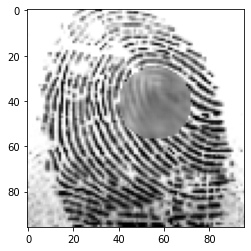

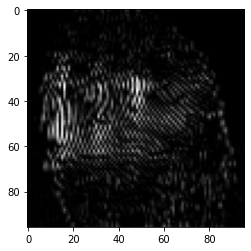

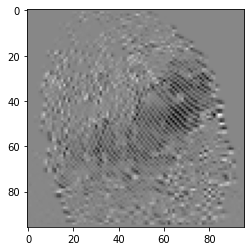

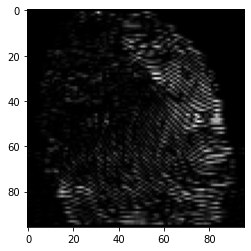

(<matplotlib.image.AxesImage at 0x273ddbd0910>, None)

In [60]:
# UNIT Test of ridge_gradient_tf
test_x = tf.convert_to_tensor(train_y[0:5])
test_x = tf.reshape(test_x, (-1, 96, 96, 1))
a,b,c,d = ridge_gradient_tf(test_x)
plt.imshow(train_x[3],'gray'), plt.show()
plt.imshow(a[3].numpy() * a[3].numpy(),'gray'), plt.show()
plt.imshow(a[3].numpy() * c[3].numpy(),'gray'), plt.show()
plt.imshow(c[3].numpy() * c[3].numpy(),'gray'), plt.show()
# plt.imshow(a[0].numpy(),'gray'), plt.show()
# plt.imshow(b[0].numpy(),'gray'), plt.show()
# plt.imshow(c[0].numpy(),'gray'), plt.show()
# plt.imshow(d[0].numpy(),'gray'), plt.show()

In [61]:
#https://stackoverflow.com/questions/3149279/optimal-sigma-for-gaussian-filtering-of-an-image
#http://www.cse.dmu.ac.uk/~sexton/WWWPages/HIPR/html/gsmooth.html
#https://stackoverflow.com/questions/61394826/how-do-i-get-to-show-gaussian-kernel-for-2d-opencv
#SIGMA = (k-1)/6
def gaussian_kernel_smoothing(kernel_len = 21, sigma=3):
    kernel = np.zeros((kernel_len, kernel_len))
    
    # a dirac delta 
    kernel[kernel_len//2, kernel_len//2] = 1
    # plt.imshow(kernel, 'gray'), plt.show()
    # a gaussian blur of dirac delta is the 2D gaussian mask filter
    return cv2.GaussianBlur(kernel, (kernel_len,kernel_len), sigmaX=sigma, sigmaY=sigma)
    

In [62]:
def ridge_orientation(images):
#     image = tf.Variable(image)
    gauss_block = np.array([gaussian_kernel_smoothing(7, 1)], dtype= np.float32)
    gauss_orient = np.array([gaussian_kernel_smoothing(31, 5)], dtype= np.float32)
    
    sobel_0 = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    sobel_90 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    # Get gaussian gradient
#     gauss_gradient_x = cv2.filter2D(gauss_block, -1, sobel_0)
#     gauss_gradient_y = cv2.filter2D(gauss_block, -1, sobel_90) # >>> 0 ???
#     gauss_gradient_y = cv2.filter2D(np.transpose(gauss_block), -1, sobel_0)
    
    gauss_gradient_x = cv2.filter2D(gauss_block.reshape(7,7), -1, sobel_0)
    gauss_gradient_y = cv2.filter2D(gauss_block.reshape(7,7), -1, sobel_90)
    
#     plt.imshow(gauss_gradient_x),plt.show()
#     plt.imshow(gauss_gradient_y), plt.show()
    
    # Get image gradients
#     print(image.shape)
    
    orient_imgs = []
    reliabilities = []
    for i, image in enumerate(images):
        
        gauss_img_x = cv2.filter2D(image.reshape(96,96), -1, gauss_gradient_x.reshape(7,7))
        gauss_img_y = cv2.filter2D(image.reshape(96,96), -1, gauss_gradient_y.reshape(7,7))

#         print(gauss_img_x.shape)
#         plt.imshow(gauss_img_x,'gray'), plt.show()
#         plt.imshow(gauss_img_y,'gray'),plt.show()

        gauss_img_xx = gauss_img_x ** 2
        gauss_img_xy = gauss_img_x * gauss_img_y
        gauss_img_yy = gauss_img_y ** 2

    #     print(gauss_img_xy[45])
    #     plt.imshow(gauss_img_xy,'gray'), plt.show()

        gauss_img_xx = cv2.filter2D(gauss_img_xx, -1, gauss_orient.reshape(31,31))
        gauss_img_xy = 2 * cv2.filter2D(gauss_img_xy, -1, gauss_orient.reshape(31,31))
        gauss_img_yy = cv2.filter2D(gauss_img_yy, -1, gauss_orient.reshape(31,31))
        print(gauss_img_xx.shape)
        plt.imshow(gauss_img_xx,'gray'), plt.show()
        plt.imshow(gauss_img_xy,'gray'), plt.show()
        plt.imshow(gauss_img_yy,'gray'), plt.show()

        # get orient img
        denom = np.sqrt(gauss_img_xy**2 + (gauss_img_xx - gauss_img_yy)**2 + 1**(-12))

        sin2theta = gauss_img_xy / denom
        cos2theta = (gauss_img_xx - gauss_img_yy) / denom

        # smooth double angle of orient img
        sin2theta = cv2.filter2D(sin2theta, -1, gauss_orient.reshape(31,31))
        cos2theta = cv2.filter2D(cos2theta, -1, gauss_orient.reshape(31,31))
    #     print(sin2theta, cos2theta)

    #     print('log')
    #     print(np.pi/2.0 + np.arctan2(sin2theta, cos2theta) / 2.0)

        orient_img = np.pi/2.0 + np.arctan2(sin2theta, cos2theta) / 2.0
        plt.imshow(orient_img), plt.show()
        # Imin Imax Rscore and coherence
#         Imin = (gauss_img_yy + gauss_img_xx) / 2.0 - (gauss_img_xx - gauss_img_yy) * cos2theta / 2.0 - gauss_img_xy * sin2theta / 2.0 
#         Imax = gauss_img_yy + gauss_img_xx - Imin

#         reliability = 1 - Imin / (Imax + 0.001)
#     #     print('denom HERE!')
#     #     print(denom.shape)
#         if (denom.all() <= 0.001):
#             reliability = 0

#         coherence = ((Imax - Imin) / (Imax + Imin + 1 ** (-12))) ** 2
        
        orient_imgs.append(orient_img)
#         reliabilities.append(reliability)
    
    return orient_imgs
#, reliabilities, coherence
    
    

(96, 96)


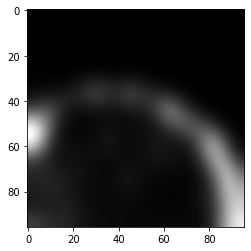

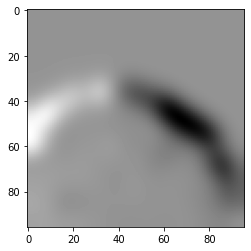

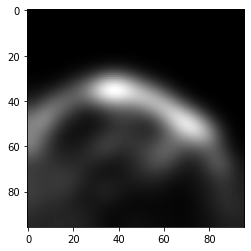

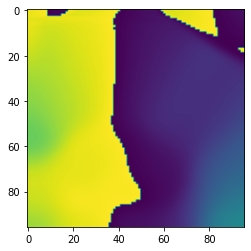

In [63]:
ans = ridge_orientation(train_x[0:1])

In [119]:
def ridge_orientation_tf(images_tf):
    gb_k_size = GAUSS_BLOCK_KERNEL_SIZE
    go_k_size = GAUSS_ORIENT_KERNEL_SIZE
    pad_size = int((go_k_size-1)/2)
    # Gauss Block and Gauss Orient have to be smaller than this because of our input img is not as big as theirs
    gauss_block = np.array([gaussian_kernel_smoothing(gb_k_size, GAUSS_BLOCK_SIGMA)], dtype= np.float32)
    gauss_orient = np.array([gaussian_kernel_smoothing(go_k_size, GAUSS_ORIENT_SIGMA)], dtype= np.float32).reshape(go_k_size,go_k_size,1,1)
#     plt.imshow(gauss_block[0],'gray'), plt.show()
#     gauss_block2 = gauss_block.reshape(7,7,1,1)
    sobel_0 = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    sobel_90 = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    gauss_gradient_x = cv2.filter2D(gauss_block.reshape(gb_k_size,gb_k_size), -1, sobel_0).reshape(gb_k_size,gb_k_size,1,1)
    gauss_gradient_y = cv2.filter2D(gauss_block.reshape(gb_k_size,gb_k_size), -1, sobel_90).reshape(gb_k_size,gb_k_size,1,1)
#     plt.imshow(gauss_gradient_x.reshape(7,7),'gray'), plt.show()
#     plt.imshow(gauss_gradient_y.reshape(7,7),'gray'), plt.show()
    
    images_tf = tf.pad(images_tf, [[0, 0], [3,3], [3, 3], [0, 0]], "REFLECT")
    gauss_img_x = tf.nn.conv2d(images_tf, gauss_gradient_x, strides=[1, 1, 1, 1], padding='VALID')
    gauss_img_y = tf.nn.conv2d(images_tf, gauss_gradient_y, strides=[1, 1, 1, 1], padding='VALID')
#     plt.imshow(gauss_img_x[3].numpy().reshape(96,96),'gray'), plt.show()
#     plt.imshow(gauss_img_y[3].numpy().reshape(96,96),'gray'), plt.show()

    gauss_img_xx = tf.math.pow(gauss_img_x, 2)
    gauss_img_xy = tf.math.multiply(gauss_img_x, gauss_img_y)
    gauss_img_yy = tf.math.pow(gauss_img_y, 2)
#     plt.imshow(gauss_img_xx[3].numpy().reshape(96,96),'gray'), plt.show()
#     plt.imshow(gauss_img_xy[3].numpy().reshape(96,96),'gray'), plt.show()
#     plt.imshow(gauss_img_yy[3].numpy().reshape(96,96),'gray'), plt.show()

    gauss_img_xx = tf.pad(gauss_img_xx, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    gauss_img_xy = tf.pad(gauss_img_xy, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    gauss_img_yy = tf.pad(gauss_img_yy, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
#  TEST
#     gauss_img_xx = tf.pad(gauss_img_xx, [[0, 0], [3,3], [3, 3], [0, 0]], "REFLECT")
#     gauss_img_xy = tf.pad(gauss_img_xy, [[0, 0], [3,3], [3, 3], [0, 0]], "REFLECT")
#     gauss_img_yy = tf.pad(gauss_img_yy, [[0, 0], [3,3], [3, 3], [0, 0]], "REFLECT")
    
    gauss_img_xx = tf.nn.conv2d(gauss_img_xx, gauss_orient, strides=[1, 1, 1, 1], padding='VALID')
    gauss_img_xy = tf.math.multiply(2, tf.nn.conv2d(gauss_img_xy, gauss_orient, strides=[1, 1, 1, 1], padding='VALID'))
    gauss_img_yy = tf.nn.conv2d(gauss_img_yy, gauss_orient, strides=[1, 1, 1, 1], padding='VALID')

#     plt.imshow(gauss_img_xx[3].numpy().reshape(96,96),'gray'), plt.show()
#     plt.imshow(gauss_img_xy[3].numpy().reshape(96,96),'gray'), plt.show()
#     plt.imshow(gauss_img_yy[3].numpy().reshape(96,96),'gray'), plt.show()
    # get orient img
    gauss_img_xx_square_diff_yy = tf.math.pow(tf.math.subtract(gauss_img_xx, gauss_img_yy), 2)
    gauss_img_xy_square = tf.math.pow(gauss_img_xy, 2)
    gauss_img_sum = tf.math.add(gauss_img_xx_square_diff_yy, gauss_img_xy_square)
    denom = tf.math.sqrt(gauss_img_sum)
    denom = tf.math.add(denom, 1**(-12))

    sin2theta = tf.math.divide(gauss_img_xy, denom)
    cos2theta = tf.math.divide(tf.math.subtract(gauss_img_xx, gauss_img_yy), denom)
    
    sin2theta2 = tf.math.divide(gauss_img_xy, denom)
    cos2theta2 = tf.math.divide(tf.math.subtract(gauss_img_xx, gauss_img_yy), denom)

    # smooth double angle of orient img
    sin2theta = tf.pad(sin2theta, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    cos2theta = tf.pad(cos2theta, [[0, 0], [pad_size,pad_size], [pad_size, pad_size], [0, 0]], "REFLECT")
    
    sin2theta = tf.nn.conv2d(sin2theta, gauss_orient, strides=[1, 1, 1, 1], padding='VALID')
    cos2theta = tf.nn.conv2d(cos2theta, gauss_orient, strides=[1, 1, 1, 1], padding='VALID')
    atan2_sin2cos2 = tf.math.atan2(sin2theta, cos2theta)
    atan2_sin2cos2_div2 = tf.math.divide(atan2_sin2cos2, 2)
    
    PI = tf.dtypes.cast(3.14159265, tf.float64)
    atan2_sin2cos2_div2 = tf.dtypes.cast(atan2_sin2cos2_div2, tf.float64)
    orient_imgs = tf.math.add(tf.math.divide(PI, 2), atan2_sin2cos2_div2)

#     Imin Imax Rscore and coherence

#(gauss_img_xy * sin2theta) / 2.0
    temp1 = tf.math.divide(tf.math.add(gauss_img_yy, gauss_img_xx), 2)#
    temp2 = tf.math.subtract(gauss_img_xx, gauss_img_yy)
    temp3 = tf.math.multiply(temp2, cos2theta)
    temp4 = tf.math.divide(temp3, -2) #
    temp5 = tf.math.divide(tf.math.multiply(gauss_img_xy, sin2theta), -2)#
    
    Imin = tf.math.add_n([temp1, temp4, temp5])
    Imax = tf.math.subtract(tf.math.add(gauss_img_yy, gauss_img_xx), Imin)

    temp6 = tf.math.subtract(1, Imin)

    reliabilities = tf.math.divide(temp6, tf.math.add(Imax, MAGIC_NUMBER_REL) )

# #     print(sin2theta.numpy().shape)
# #     print(denom[3].numpy())
# #     Test print vector field 
# #     n = 8
#     X, Y = np.mgrid[0:10, 0:10]
# #     T = np.arctan2(Y - n / 2., X - n/2.)
# #     R = 10 + np.sqrt((Y - n / 2.0) ** 2 + (X - n / 2.0) ** 2)
# #     U, V = R * np.cos(T), R * np.sin(T)

#     plt.axes([0.025, 0.025, 0.95, 0.95])
# #     plt.quiver(gauss_img_x[3].numpy().reshape(96,96), gauss_img_y[3].numpy().reshape(96,96), sin2theta2[3].numpy().reshape(96,96), cos2theta2[3].numpy().reshape(96,96), 1, alpha=.5)
# #     plt.quiver(gauss_img_x[3].numpy().reshape(96,96), gauss_img_y[3].numpy().reshape(96,96), sin2theta2[3].numpy().reshape(96,96), cos2theta2[3].numpy().reshape(96,96), edgecolor='red', facecolor='red', linewidth=.3)
#     x, y = X,  Y
#     u, v = cos2theta2[3].numpy().reshape(96,96), sin2theta2[3].numpy().reshape(96,96)
    
# #     u = u[30:40, 30:40]
# #     v = v[30:40, 30:40]
# #     print(u.shape)
# #     print(v.shape)
# #     print(x.shape)
# #     print(y.shape)
# #     plt.quiver(x,y,u,v)
# # #     plt.xlim(-1, 1)
# # #     plt.xticks([])
# # #     plt.ylim(-1, 1)
# # #     plt.yticks([])
# #     plt.savefig("orientation.png")
# #     plt.show()
    

# #     plt.imshow(reliabilities[3]*255, 'gray'), plt.show()
    return orient_imgs, reliabilities
#, reliabilities

AAAAAAAAAAAA
(1, 96, 96, 1)
BBBBBBBBBBBBBB
(1, 96, 96, 1)


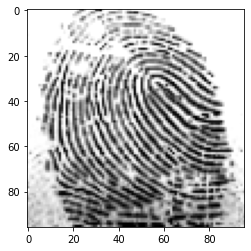

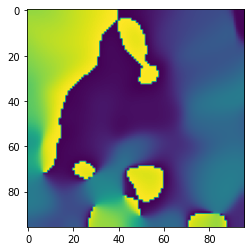

tf.Tensor(
[[[[1.        ]
   [1.        ]
   [1.        ]
   ...
   [1.        ]
   [1.        ]
   [1.        ]]

  [[1.        ]
   [1.        ]
   [1.        ]
   ...
   [1.        ]
   [1.        ]
   [1.        ]]

  [[1.        ]
   [1.        ]
   [1.        ]
   ...
   [0.99999999]
   [0.99999999]
   [0.99999999]]

  ...

  [[0.91337397]
   [0.9098402 ]
   [0.89990872]
   ...
   [0.96463599]
   [0.96327122]
   [0.9628207 ]]

  [[0.91973471]
   [0.91630783]
   [0.90665885]
   ...
   [0.96461625]
   [0.96327748]
   [0.96283709]]

  [[0.92190025]
   [0.91851154]
   [0.90896353]
   ...
   [0.96463597]
   [0.96330763]
   [0.96287127]]]], shape=(1, 96, 96, 1), dtype=float64)


In [121]:
# UNIT Test of ridge_orient_tf
test_x = tf.convert_to_tensor(train_y[5:6])
test_x = tf.reshape(test_x, (-1, 96, 96, 1))
a,b = ridge_orientation_tf(test_x)
print('AAAAAAAAAAAA')
print(a.shape)
print('BBBBBBBBBBBBBB')
print(b.shape)
plt.imshow(train_y[3],'gray'), plt.show()
plt.imshow(tf.reshape(a, ( 96, 96))), plt.show()
print(b)

In [66]:
def mse(a,b):
    return tf.reduce_mean((a -b)**2)

In [67]:
#https://towardsdatascience.com/custom-loss-function-in-tensorflow-2-0-d8fa35405e4e
#https://stackoverflow.com/questions/34875944/how-to-write-a-custom-loss-function-in-tensorflow
def loss_fn(input_img_tf, output_img_tf):
    # -- get numpy of tf -- #
    input_img = input_img_tf.numpy()
    output_img = output_img_tf.numpy()
    
    #---- gradient loss ----#
    grad_0_in, grad_45_in, grad_90_in, grad_135_in = tf.convert_to_tensor(ridge_gradient(input_img))
    grad_0_out, grad_45_out, grad_90_out, grad_135_out = tf.convert_to_tensor(ridge_gradient(output_img))
    

    cost0 = tf.keras.losses.MSE(grad_0_out, grad_0_in)
    cost45 = tf.keras.losses.MSE(grad_45_out, grad_45_in)
    cost90 = tf.keras.losses.MSE(grad_90_out, grad_90_in)
    cost135 = tf.keras.losses.MSE(grad_135_out, grad_135_in)
#     cost0 = mse(grad_0_out, grad_0_in)
#     cost45 = mse(grad_45_out, grad_45_in)
#     cost90 = mse(grad_90_out, grad_90_in)
#     cost135 = mse(grad_135_out, grad_135_in)
    
    grad_loss_sum = tf.math.add_n([cost0, cost45, cost90, cost135])
    grad_loss = tf.math.divide(grad_loss_sum, 4)

    # TODO OVER HERE >>> แก้ ride_orient
    
    #---- orientation loss and reliability loss ----#
#     ori_in, rel_in, _ = ridge_orientation(input_img)
#     ori_out, rel_out, _ = ridge_orientation(output_img)
    
    ori_in_tf = tf.convert_to_tensor(ridge_orientation(input_img))
#     rel_in_tf = tf.convert_to_tensor(ridge_orientation_rel(input_img))
    ori_out_tf = tf.convert_to_tensor(ridge_orientation(output_img))
#     rel_out_tf = tf.convert_to_tensor(ridge_orientation_rel(output_img))
    
    ori_loss = tf.keras.losses.MSE(ori_out_tf, ori_in_tf)
#     rel_loss = tf.keras.losses.MSE(rel_out_tf, rel_in_tf)
#     ori_loss = mse(ori_out, ori_in)
#     rel_loss = mse(rel_out, rel_in)
      
#     sum_loss = tf.math.add_n([grad_loss, ori_loss, rel_loss])
    sum_loss = tf.math.add_n([grad_loss, ori_loss])
#     loss = tf.math.divide(sum_loss, 3)
    loss = tf.math.divide(sum_loss, 2)
    
    return loss
#, grad_loss, ori_loss, rel_loss

In [68]:
def loss_fn_tf(input_img_tf, output_img_tf):
    
    #---- gradient loss ----#
    grad_0_in, grad_45_in, grad_90_in, grad_135_in = ridge_gradient_tf(input_img_tf)
    grad_0_out, grad_45_out, grad_90_out, grad_135_out = ridge_gradient_tf(output_img_tf)
    
    cost0 = tf.math.reduce_mean(tf.keras.losses.MSE(grad_0_out, grad_0_in),axis = (-1,1))
    cost45 = tf.math.reduce_mean(tf.keras.losses.MSE(grad_45_out, grad_45_in),axis = (-1,1))
    cost90 = tf.math.reduce_mean(tf.keras.losses.MSE(grad_90_out, grad_90_in),axis = (-1,1))
    cost135 = tf.math.reduce_mean(tf.keras.losses.MSE(grad_135_out, grad_135_in),axis = (-1,1))
                                 

    grad_loss_sum = tf.math.add_n([cost0, cost45, cost90, cost135])
    grad_loss = tf.math.divide(grad_loss_sum, 4)
    grad_loss = tf.math.multiply(grad_loss, GRAD_WEIGHT)
    
   
    #---- orientation loss and reliability loss ----#
    
    ori_in_tf, rel_in_tf = ridge_orientation_tf(input_img_tf)
    ori_out_tf, rel_out_tf = ridge_orientation_tf(output_img_tf)

    
    ori_loss = tf.math.reduce_mean(tf.keras.losses.MSE(ori_out_tf, ori_in_tf),axis = (-1,1))
    rel_loss = tf.math.reduce_mean(tf.keras.losses.MSE(rel_out_tf, rel_in_tf),axis = (-1,1))
    
    ori_loss = tf.math.multiply(ori_loss, ORI_WEIGHT)
    rel_loss = tf.math.multiply(rel_loss, REL_WEIGHT)
#     ori_loss = mse(ori_out, ori_in)
#     rel_loss = mse(rel_out, rel_in)
      

    #sum_loss = tf.math.add_n([grad_loss, ori_loss])
    total_weight = GRAD_WEIGHT + ORI_WEIGHT + REL_WEIGHT
    sum_loss = tf.math.add_n([grad_loss, ori_loss, rel_loss])
    loss = tf.math.divide(sum_loss, total_weight)
    #loss = tf.math.divide(sum_loss, 2)
    
    return loss

In [69]:
xxx = tf.reshape(tf.convert_to_tensor(train_x[1:10]), (-1,96,96,1))
yyy = tf.reshape(tf.convert_to_tensor(train_y[1:10]), (-1,96,96,1))
loss_fn_tf(xxx,yyy)

<tf.Tensor: shape=(9,), dtype=float64, numpy=
array([0.11811487, 0.04631837, 0.42790589, 0.0822446 , 0.40923065,
       0.17606651, 0.43667204, 0.25309967, 0.20702355])>

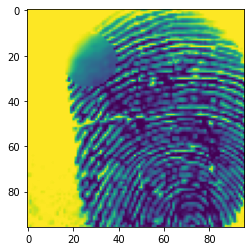

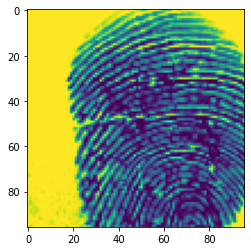

In [70]:
plt.imshow(train_x[2])
plt.show()
plt.imshow(train_y[2])
plt.show()

# GPU

In [71]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [72]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Training the model

In [89]:
len(train_x)

9100

In [90]:
WEIGHT_SAVING_PATH = 'E:/ModelWeight/gae/'

In [91]:
def train(model, train_x, train_y, batch_size, epochs, exp_id):
#     img = tf.Variable(img)
# opt = tf.optimizers.Adam(learning_rate=lr, decay = 1e-6)

# for _ in range(epoch):
#     with tf.GradientTape() as tape:
#         tape.watch(img)
#         y = model(img.value())[:, :, :, filter]
#         loss = -tf.math.reduce_mean(y)

#     grads = tape.gradient(loss, img)
#     opt.apply_gradients(zip([grads], [img]))
    optimizers = Adam(learning_rate=LR, beta_1=MOMENTUM, decay=WEIGHT_DECAY, epsilon=EPSILON)

    batch_round = math.ceil(len(train_x) / batch_size)
    
    loss = []
    grad_loss = []
    ori_loss = []
    rel_loss = []
    min_epoch_loss = 1e3
    
    for epoch in range(epochs):
        start_time_epoch = datetime.datetime.now()
        epoch_cumulative_loss = 0
        epoch_loss = 0
        print('epoch:', epoch, 'start...')
        print('training|', end = '')
        for batch in range(batch_round):
            start_time_batch = datetime.datetime.now()
            
            batch_start = batch * batch_size
            batch_end = (batch_start + batch_size)
            
            image_x_batched = tf.convert_to_tensor(train_x[batch_start: batch_end])
            image_y_batched = tf.convert_to_tensor(train_y[batch_start: batch_end])
            
#             for i in range(1):
#                 print(i)
            with tf.GradientTape() as tape:

                tape.watch(model.trainable_variables)
                enhanced_image = model(tf.reshape(image_x_batched, (-1,96,96)))
                total_loss = loss_fn_tf(tf.reshape(image_y_batched, (image_y_batched.shape[0],image_y_batched.shape[1],image_y_batched.shape[2],1)), enhanced_image)

            gradients_of_model = tape.gradient(total_loss, model.trainable_variables)
#                 print('grad of model')
#                 print(gradients_of_model)
            optimizers.apply_gradients(zip(gradients_of_model, model.trainable_variables))
    
            if (np.isnan(total_loss.numpy()).any()):
                print('this batch is NaN: ',str(batch))
                
            batch_mean_loss = tf.math.reduce_mean(total_loss)
            loss.append(batch_mean_loss)
            epoch_cumulative_loss = epoch_cumulative_loss + batch_mean_loss
            if (batch % 5 == 0):
                print('*', end = '')
            
            if (batch == batch_round-1):
                epoch_loss = epoch_cumulative_loss / batch_round
                print('||', end = '')
#             grad_loss.append(grad_l)
#             ori_loss.append(ori_l)
#             rel_loss.append(rel_l)
            elapsed_time = datetime.datetime.now() - start_time_batch
#             print('batch:', batch, 'elapsed time:', elapsed_time)
            
        
        # SAVE MODELS
        print('end of epoch: ', epoch)
        print('time used: ', datetime.datetime.now() - start_time_epoch)
        print('EPOCH LOSS:', epoch_loss)
        print('='*25)
        if(epoch_loss < min_epoch_loss):
            print("Loss Improved!")
            model.save(WEIGHT_SAVING_PATH + 'gae_'+ str(exp_id) +'e'+ str(epoch) +'.h5')
            min_epoch_loss = epoch_loss
            print('='*25)
        
            
    return loss, grad_loss, ori_loss, rel_loss

In [92]:
#check saving path
print(WEIGHT_SAVING_PATH + 'gae_'+ str(1) +'e'+ str(1) +'.h5')

E:/ModelWeight/gae/gae_1e1.h5


In [93]:
loss, _,_,_ = train(model, train_x, train_y, BATCH_SIZE, EPOCH, EXPERIMENTAL_ID)

epoch: 0 start...
training|*************||end of epoch:  0
time used:  0:09:01.306892
EPOCH LOSS: tf.Tensor(2.2491948555557544, shape=(), dtype=float64)
epoch: 1 start...
training|*************||end of epoch:  1
time used:  0:09:02.247462
EPOCH LOSS: tf.Tensor(2.1606971114110824, shape=(), dtype=float64)
epoch: 2 start...
training|*************||end of epoch:  2
time used:  0:08:59.620573
EPOCH LOSS: tf.Tensor(1.8383791307794672, shape=(), dtype=float64)
epoch: 3 start...
training|*************||end of epoch:  3
time used:  0:09:01.904370
EPOCH LOSS: tf.Tensor(1.640449165905643, shape=(), dtype=float64)
epoch: 4 start...
training|*************||end of epoch:  4
time used:  0:09:00.211119
EPOCH LOSS: tf.Tensor(1.5078839677376408, shape=(), dtype=float64)
epoch: 5 start...
training|*************||end of epoch:  5
time used:  0:08:59.765750
EPOCH LOSS: tf.Tensor(1.316862946388603, shape=(), dtype=float64)
epoch: 6 start...
training|*************||end of epoch:  6
time used:  0:09:00.72741

In [94]:
loss = np.array(loss)

In [95]:
loss.shape

(3250,)

In [96]:
loss[0]

2.389079532880324

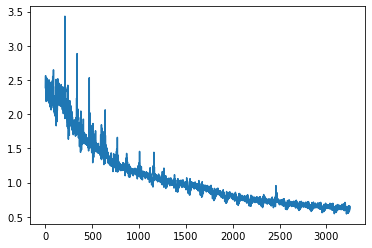

In [97]:
plt.plot(loss[:])

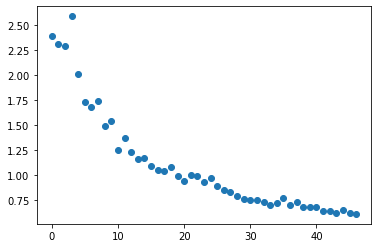

In [98]:
plt.plot(loss[::70],'o')

In [107]:
testsample = train_x[100].reshape(1,96,96,1)

In [108]:
test_result = model.predict(testsample)

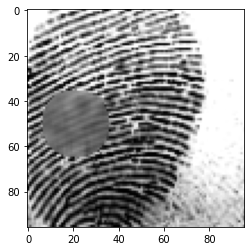

In [109]:
plt.imshow(train_x[100],'gray')

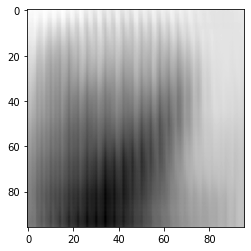

In [110]:
plt.imshow(test_result.reshape(96,96),'gray')